<a href="https://colab.research.google.com/github/software-artisan/computer_vision_eva6_tsai/blob/main/assignment_6_batch_norm_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from collections import OrderedDict


In [2]:
def get_norm_layer( norm_layer_type, num_channels, num_groups_for_group_norm=None):
    """
    norm_layer_type: 'batch' | 'group' | 'layer'
    num_channels: # of channels
    """
    if norm_layer_type == "batch":
        # Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift <https://arxiv.org/abs/1502.03167>__ .        #
        # The mean and standard-deviation are calculated per-dimension over the mini-batches and \gamma and \beta are learnable parameter vectors of size C (where C is the input size). By default, the elements of \gamma are set to 1 and the elements of \beta are set to 0. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).        #
        # def __init__(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        nl = nn.BatchNorm2d(num_features=num_channels)
    elif norm_layer_type == "group":
        # Applies Group Normalization over a mini-batch of inputs as described in the paper Group Normalization
        # The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. \gammaγ and \betaβ are learnable per-channel affine transform parameter vectors of size num_channels if affine is True. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).
        nl = nn.GroupNorm(num_groups=num_groups_for_group_norm, num_channels=num_channels)
    elif norm_layer_type == "layer":
        # a group size of '1' uses all the 'features'/channels of the image: essentially a 'layer norm'
        nl = nn.GroupNorm(num_groups=1, num_channels=num_channels)

    return nl

In [3]:
class Net(nn.Module):
    def __init__(self, norm_layer_type, num_groups_for_group_norm=None):
        """
        norm_layer_type: 'batch' | 'group' | 'layer'
        """
        super(Net, self).__init__()
        
        dropout=0.05
 
        ####### 
        # Convolution Block #1
        #########
        self.conv1_1_3_3_8_p = nn.Sequential(OrderedDict([
            ('conv1_1_3_3_8_p', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False)),
            ('relu', nn.ReLU()),
            ('batchNorm2d', get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm) ),
            ('dropOut2d', nn.Dropout2d(p=dropout))
          ])
        ) # Input=28, Output=28, rf=3

        self.conv2_8_3_3_8_p = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=28, Output=28, rf=5
 
        self.conv3_8_3_3_8_p = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=28, Output=28, rf=10
 
        ####### 
        # Transition Block #1
        #########
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Input=28, Output=14, rf=6
 
        self.conv4_8_1_1_16 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=1, padding=0, bias=False),
        ) # Input=14, Output=14, rf=32
 
        ####### 
        # Convolution Block #2
        #########
        self.conv5_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=14, Output=12, rf=14
 
        self.conv6_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) # Input=12, Output=10, rf=24
        )
        
        self.conv7_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) # Input=10, Output=8, rf=24
        )
        
        self.conv8_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=8, Output=6, rf=24

        self.conv9_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=6, Output=4, rf=24
        
        self.maxpool2= nn.MaxPool2d(kernel_size=2, stride=2) # Input=4, Output=2, rf=16
 
        ####### 
        # Output Block
        #########
        # global average pool before 1x1 to reduce computation
        self.global_avgpool = nn.AdaptiveAvgPool2d(output_size=1)  # Input=5, Output=1, rf=40
 
        self.conv10_16_1_1_10 = nn.Sequential(
            #nn.Conv2d(in_channels=14, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=1, padding=0, bias=False),
        ) # Input=1, Output=1, rf=32
    
    def forward(self, x):
        #####
        # conv block #1
        ########
        x = self.conv1_1_3_3_8_p(x)
        x = self.conv2_8_3_3_8_p(x)
        x = self.conv3_8_3_3_8_p(x)
 
        #####
        # Transitioni block #1
        ########
        x = self.maxpool1(x)
        x = self.conv4_8_1_1_16(x)
 
        #####
        # conv block #2
        ########
        x = self.conv5_12_3_3_12(x)
        x = self.conv6_12_3_3_12(x)
        x = self.conv7_12_3_3_12(x)
        x = self.conv8_12_3_3_12(x)
        x = self.conv9_12_3_3_12(x)

        #######
        # Transition block #2
        #######
        x = self.maxpool2(x)
 
        #####
        # output block
        ########
        x = self.global_avgpool(x)        
        x = self.conv10_16_1_1_10(x)
               
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net('batch').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
      BatchNorm2d-11            [-1, 8, 28, 28]              16
        Dropout2d-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
# SEED=1 so that we use the same random images for training, during each mini batch, during each epoch
SEED=1
torch.manual_seed(SEED)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# download training data set: 50,000 images
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# download test data set: 10,000 images
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
from tqdm import tqdm
from dataclasses import dataclass
from typing import Any

@dataclass
class TrainTestLossAccuracy:
    test_loss_list:list
    test_acc_list:list
    train_loss_list:list
    train_acc_list:list


train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(epoch, model, device, train_loader, optimizer, train_test_loss_acc:TrainTestLossAccuracy, lambda_l1=None, num_batches=None ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  #loss_epoch:torch.Tensor=None
  loss_epoch:float=None

  for batch_idx, (data, y_target) in enumerate(pbar):
    # get samples of 'batchsize'        
    data, y_target = data.to(device), y_target.to(device)  # (Pdb) p data.shape=torch.Size([128, 1, 28, 28]); #(Pdb) y_target.shape = torch.Size([128])

    # So zero out the gradients before starting backpropragation because, without this, PyTorch accumulates gradients on subsequent backward passes. 
    optimizer.zero_grad()

    # predict
    y_pred = model(data)     # (Pdb) y_pred.shape = torch.Size([128, 10])

    # Calculate loss
    # input – (N, C) where N=<batch size> and C = number of classes or (N, C, H, W) in case of 2D Loss, or (N, C, d_1, d_2, ..., d_K)....
    # target – (N) where N=<batch size> and each value is 0 < targets[i] < C-1. ...
    loss = F.nll_loss(y_pred, y_target)     # negative log likelihood; this is a 1x1 tensor; see below
    # print(f"repr(loss)={repr(loss)}; loss.size()={loss.size()}") # repr(loss)=tensor(2.4530, grad_fn=<NllLossBackward>);  tensor(2.3594, grad_fn=<AddBackward0>)

    # if l1 regularization applies, do it..
    if lambda_l1:
      l1_loss = 0
      for p in model.parameters():
        l1_loss = l1_loss + p.abs().sum()
      loss = loss + lambda_l1 * l1_loss    # add l1 loss..

    train_losses.append(loss)
    #import pdb; pdb.set_trace()
    if not loss_epoch: 
      # loss_epoch = loss.clone().detach(); # if clone().detach() is not used, then loss_epoch and loss point to the same underlying tensor, which is not what we want; we want a copy; in addition, we do not want loss_epoch to participate in the compuation graph computed by pytorch
      loss_epoch = loss.item()
    else:
      #loss_epoch = loss_epoch + loss
      loss_epoch = loss_epoch + loss.item()
    
    #print(f"repr(loss_epoch)={repr(loss_epoch)}; loss_epoch.size()={loss_epoch.size()}")   # tensor(2.3594, grad_fn=<AddBackward0>)
    #print(f"repr(loss_epoch)={repr(loss_epoch)}; ")
    #print(f"repr(loss)={repr(loss)}; loss.size()={loss.size()}")

    loss.backward()  # do backpropagation across the graph:  dho(loss)/dho(weight)
    optimizer.step() # adjust the weights

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max element
    correct += pred.eq(y_target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Train phase: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    if num_batches and batch_idx == num_batches: break
  
  train_acc.append(100*correct/processed)

  #loss_epoch /= len(train_loader.dataset)
  train_test_loss_acc.train_loss_list.append(loss_epoch)
  train_test_loss_acc.train_acc_list.append(100*correct/processed)

  return train_test_loss_acc


def test(epoch, model, device, test_loader,train_test_loss_acc:TrainTestLossAccuracy, num_batches=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, y_target) in enumerate(test_loader):
            data, y_target = data.to(device), y_target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, y_target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y_target.view_as(pred)).sum().item()

            if num_batches and batch_idx == num_batches: break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    train_test_loss_acc.test_loss_list.append(test_loss)

    print(f'\nTest phase: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    train_test_loss_acc.test_acc_list.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR

def run_train_and_test(epochs, norm_type, num_groups_for_group_norm=None, lambda_l1=None, lambda_l2=None, num_batches=None) -> TrainTestLossAccuracy: 
  model =  Net(norm_layer_type=norm_type, num_groups_for_group_norm=num_groups_for_group_norm).to(device)
  
  if lambda_l2:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=lambda_l2)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  
  scheduler = StepLR(optimizer, step_size=3, gamma=0.09)   # after the specified 'step_size', scale(multiply) the current LR by the specified gamma..
  
  train_test_loss_acc = TrainTestLossAccuracy([],[],[],[])
  for epoch in range(epochs):
      print("Epoch:", epoch+1)
      train(epoch, model, device, train_loader, optimizer, train_test_loss_acc, lambda_l1, num_batches=num_batches)
      test(epoch, model, device, test_loader, train_test_loss_acc, num_batches=num_batches)
      scheduler.step()
  
  return train_test_loss_acc

# Group Normalization + L1 Regularization (Train and Test)

In [8]:
train_test_loss_acc_group:TrainTestLossAccuracy = run_train_and_test(epochs=15, norm_type='group', num_groups_for_group_norm=2, lambda_l1=0.0001) #, num_batches=2)
#print(f"train_test_loss_acc={train_test_loss_acc}")

Epoch:

  0%|          | 0/469 [00:00<?, ?it/s]

 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train phase: Loss=0.32082152366638184 Batch_id=468 Accuracy=87.53: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.1085, Accuracy: 9671/10000 (96.71%)

Epoch: 2


Train phase: Loss=0.210923969745636 Batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0720, Accuracy: 9775/10000 (97.75%)

Epoch: 3


Train phase: Loss=0.1904183030128479 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0766, Accuracy: 9755/10000 (97.55%)

Epoch: 4


Train phase: Loss=0.1460486501455307 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0406, Accuracy: 9872/10000 (98.72%)

Epoch: 5


Train phase: Loss=0.23353645205497742 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0379, Accuracy: 9877/10000 (98.77%)

Epoch: 6


Train phase: Loss=0.11945942044258118 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

Epoch: 7


Train phase: Loss=0.21120452880859375 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0360, Accuracy: 9886/10000 (98.86%)

Epoch: 8


Train phase: Loss=0.14864788949489594 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0357, Accuracy: 9888/10000 (98.88%)

Epoch: 9


Train phase: Loss=0.1258319765329361 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9892/10000 (98.92%)

Epoch: 10


Train phase: Loss=0.18073013424873352 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9892/10000 (98.92%)

Epoch: 11


Train phase: Loss=0.1428346335887909 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

Epoch: 12


Train phase: Loss=0.14865554869174957 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

Epoch: 13


Train phase: Loss=0.20575594902038574 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

Epoch: 14


Train phase: Loss=0.16450434923171997 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

Epoch: 15


Train phase: Loss=0.20039743185043335 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test phase: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)



# Layer Normalization + L2 Regularization (train and test)

In [9]:
train_test_loss_acc_layer:TrainTestLossAccuracy = run_train_and_test(epochs=15, norm_type='layer', lambda_l2=0.0001)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train phase: Loss=0.12241289019584656 Batch_id=468 Accuracy=88.75: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0707, Accuracy: 9785/10000 (97.85%)

Epoch: 2


Train phase: Loss=0.144417405128479 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0527, Accuracy: 9845/10000 (98.45%)

Epoch: 3


Train phase: Loss=0.03450969234108925 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0492, Accuracy: 9860/10000 (98.60%)

Epoch: 4


Train phase: Loss=0.07297102361917496 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0321, Accuracy: 9895/10000 (98.95%)

Epoch: 5


Train phase: Loss=0.016607951372861862 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0310, Accuracy: 9901/10000 (99.01%)

Epoch: 6


Train phase: Loss=0.12576821446418762 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0304, Accuracy: 9904/10000 (99.04%)

Epoch: 7


Train phase: Loss=0.015357408672571182 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0299, Accuracy: 9906/10000 (99.06%)

Epoch: 8


Train phase: Loss=0.05318772420287132 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

Epoch: 9


Train phase: Loss=0.015301329083740711 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9910/10000 (99.10%)

Epoch: 10


Train phase: Loss=0.08834408968687057 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9910/10000 (99.10%)

Epoch: 11


Train phase: Loss=0.014952274970710278 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9909/10000 (99.09%)

Epoch: 12


Train phase: Loss=0.23025530576705933 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

Epoch: 13


Train phase: Loss=0.05261221155524254 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

Epoch: 14


Train phase: Loss=0.04065822809934616 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

Epoch: 15


Train phase: Loss=0.03745094686746597 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]



Test phase: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)



# Batch Normalization + L1 + L2 Regularization (train and test)

In [10]:
train_test_loss_acc_batch:TrainTestLossAccuracy = run_train_and_test(epochs=15, norm_type='batch', lambda_l1=0.0001, lambda_l2=0.0001)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train phase: Loss=0.15465107560157776 Batch_id=468 Accuracy=91.85: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0560, Accuracy: 9827/10000 (98.27%)

Epoch: 2


Train phase: Loss=0.2705262303352356 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0497, Accuracy: 9849/10000 (98.49%)

Epoch: 3


Train phase: Loss=0.1572943478822708 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0373, Accuracy: 9887/10000 (98.87%)

Epoch: 4


Train phase: Loss=0.180307537317276 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

Epoch: 5


Train phase: Loss=0.17886775732040405 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

Epoch: 6


Train phase: Loss=0.18489380180835724 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0210, Accuracy: 9944/10000 (99.44%)

Epoch: 7


Train phase: Loss=0.2123073935508728 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

Epoch: 8


Train phase: Loss=0.1784532368183136 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

Epoch: 9


Train phase: Loss=0.1833915114402771 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

Epoch: 10


Train phase: Loss=0.09781239926815033 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

Epoch: 11


Train phase: Loss=0.2401123344898224 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0207, Accuracy: 9944/10000 (99.44%)

Epoch: 12


Train phase: Loss=0.10855662077665329 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0208, Accuracy: 9944/10000 (99.44%)

Epoch: 13


Train phase: Loss=0.15055304765701294 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

Epoch: 14


Train phase: Loss=0.1798054277896881 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)

Epoch: 15


Train phase: Loss=0.13189366459846497 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test phase: Average loss: 0.0208, Accuracy: 9942/10000 (99.42%)



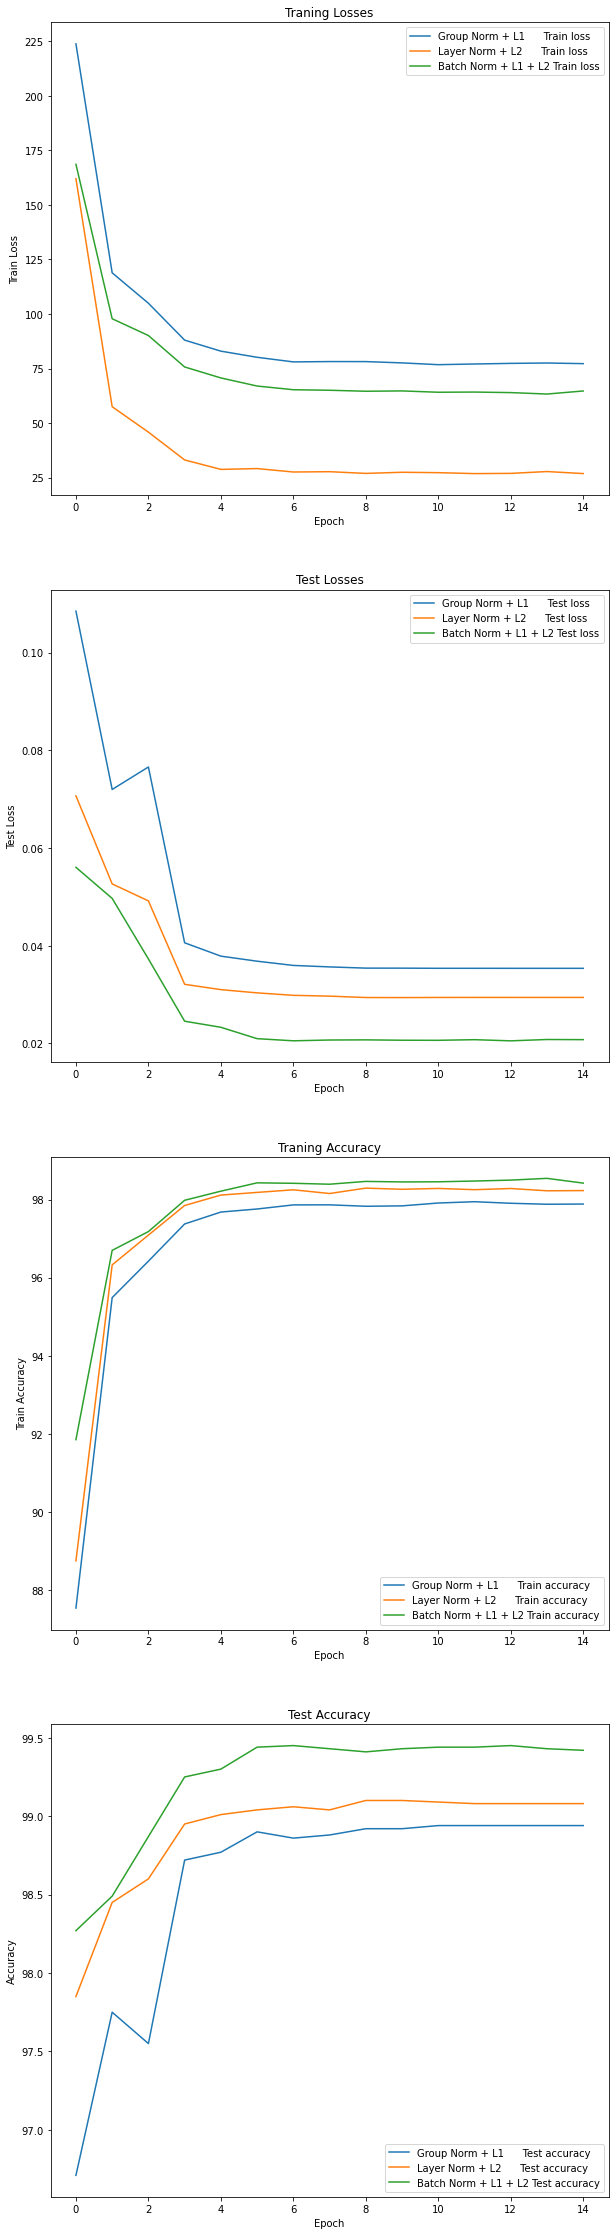

In [11]:
import matplotlib.pyplot as plt
def plot_train_test_loss_acc(train_test_loss_acc_group:TrainTestLossAccuracy, train_test_loss_acc_layer:TrainTestLossAccuracy, train_test_loss_acc_batch:TrainTestLossAccuracy):
    ax_train_loss:AxesSubplot; ax_test_loss:AxesSubplot; ax_train_acc:AxesSubplot; ax_test_acc:AxesSubplot;
    fig, (ax_train_loss, ax_test_loss,ax_train_acc,ax_test_acc) = plt.subplots(4,1, figsize=(10,40))

    ax_train_loss.plot(train_test_loss_acc_group.train_loss_list, label="Group Norm + L1      Train loss")
    ax_train_loss.plot(train_test_loss_acc_layer.train_loss_list, label="Layer Norm + L2      Train loss")
    ax_train_loss.plot(train_test_loss_acc_batch.train_loss_list, label="Batch Norm + L1 + L2 Train loss")
    ax_train_loss.legend()
    ax_train_loss.set_xlabel("Epoch")
    ax_train_loss.set_ylabel("Train Loss")
    ax_train_loss.set_title("Traning Losses")
    
    ax_test_loss.plot(train_test_loss_acc_group.test_loss_list, label="Group Norm + L1      Test loss")
    ax_test_loss.plot(train_test_loss_acc_layer.test_loss_list, label="Layer Norm + L2      Test loss")
    ax_test_loss.plot(train_test_loss_acc_batch.test_loss_list, label="Batch Norm + L1 + L2 Test loss")
    ax_test_loss.legend()
    ax_test_loss.set_xlabel("Epoch")
    ax_test_loss.set_ylabel("Test Loss")
    ax_test_loss.set_title("Test Losses")

    ax_train_acc.plot(train_test_loss_acc_group.train_acc_list, label="Group Norm + L1      Train accuracy")
    ax_train_acc.plot(train_test_loss_acc_layer.train_acc_list, label="Layer Norm + L2      Train accuracy")
    ax_train_acc.plot(train_test_loss_acc_batch.train_acc_list, label="Batch Norm + L1 + L2 Train accuracy")
    ax_train_acc.legend()
    ax_train_acc.set_xlabel("Epoch")
    ax_train_acc.set_ylabel("Train Accuracy")
    ax_train_acc.set_title("Traning Accuracy")

    ax_test_acc.plot(train_test_loss_acc_group.test_acc_list, label="Group Norm + L1      Test accuracy")
    ax_test_acc.plot(train_test_loss_acc_layer.test_acc_list, label="Layer Norm + L2      Test accuracy")
    ax_test_acc.plot(train_test_loss_acc_batch.test_acc_list, label="Batch Norm + L1 + L2 Test accuracy")
    ax_test_acc.legend()
    ax_test_acc.set_xlabel("Epoch")
    ax_test_acc.set_ylabel("Test Accuracy")
    ax_test_acc.set_title("Test Accuracy")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

plot_train_test_loss_acc(train_test_loss_acc_group, train_test_loss_acc_layer, train_test_loss_acc_batch)
# plot_train_test_loss_acc(TrainTestLossAccuracy(range(0,15), range(0,15), range(0,15), range(0,15)), 
#                          TrainTestLossAccuracy(range(1,16), range(1,16), range(1,16), range(1,16)), 
#                          TrainTestLossAccuracy(range(2,17), range(2,17), range(2,17), range(2,17)))

In [12]:
import matplotlib.pyplot as plt
def plot_accuracy(train_accuracy_list, test_accuracy_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_acc, label="Train Accuracy")
    axs.plot(test_acc, label="Test Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

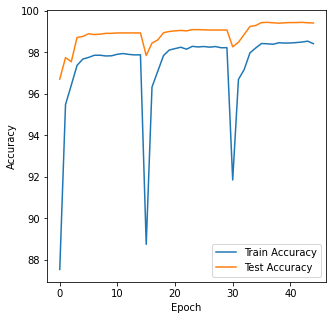

In [13]:
plot_accuracy(train_acc, test_acc)